In [129]:
import os
import numpy as np
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
#sns.set(style="darkgrid")
from keras.models import load_model

In [2]:
df = pd.read_excel("time_series.xlsx")

In [3]:
df = df.iloc[:,1:2881]

In [4]:
df = df.dropna()

In [5]:
df = df.reset_index(drop=True)

In [6]:
#display(df)

In [7]:
def isSubArray(A, B, n, m, st):
    ii = st
    j = 0
    while (ii < n and j < m): 
        if (A[ii] == B[j]): 
            ii += 1 
            j += 1 
            if (j == m): 
                return ii,True
        else: 
            ii = ii - j + 1 
            j = 0 
    return ii,False 

In [8]:
l = []
for i in df.index:
    xx = df.iloc[i][:250].values
    r = isSubArray(xx.tolist(),[0,0,0,0], 250, 4,0)
    if(r[1]):
        l.append((i, r[0]))                      # i=index, r[0]='timestamp', r[1]=fault
l = pd.DataFrame(l)

In [9]:
df = df.drop(l[0])

In [10]:
df = df.reset_index(drop=True)

In [11]:
#df

# faults

In [12]:
l = []
for i in df.index:
    xx = df.iloc[i][250:].values
    r = isSubArray(xx.tolist(),[0,0,0,0], len(xx), 4,0)
    if(r[1]):
        l.append((i, r[0]))
l = pd.DataFrame(l)

In [13]:
# l: 0=index, 1='timestamp', 2=fault
X_fault_indices = pd.DataFrame(zip(l[0], l[1], l[1].apply(lambda t: list(range(t-4, t+250-4))))) # l[1] is already fault-250
X_fault = []
for i in X_fault_indices.values:
    X_fault.append([i[0], list(df.iloc[i[0], i[2]])])
    
X_fault = pd.DataFrame(X_fault)                 # 0 - df index for future use
X_fault = pd.DataFrame(list(X_fault[1].values))

y is just an list of ones. test_train_split() will divide properly

# no fault
selected randomly from !l

In [14]:
mask = pd.Series(len(df) * [True])
mask[l[0]] = False
no_faults = df[mask]

In [15]:
def no_faults_fun():
    X_no_faults = []

    for i in no_faults.index:
        r = np.random.randint(df.shape[1] - 250)
        X_no_faults.append([i, list(df.iloc[i,r:r+250])])

    return pd.DataFrame(list( pd.DataFrame(X_no_faults)[1].values ))
X_no_faults = no_faults_fun()

In [16]:
X = pd.concat([X_fault, X_no_faults])
y = pd.DataFrame([1]*len(X_fault) + [0]*len(X_no_faults))

In [100]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [101]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

x_train = pd.concat([x_train, no_faults_fun()]).reset_index(drop=True)
y_train = pd.concat([y_train, pd.DataFrame([0]*len(X_no_faults))]).reset_index(drop=True)

In [102]:
mask = y_train[0]==1
x_train = pd.concat([x_train, x_train[mask]]).reset_index(drop=True)
y_train = pd.concat([y_train, y_train[mask]]).reset_index(drop=True)
#mask = y_train==1
#x_train = pd.concat([x_train, x_train[mask]])
#y_train = pd.concat([y_train, y_train[mask]])

In [103]:
len(y_train[y_train[0]==0])/len(y_train)

0.6256038647342995

In [104]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
y_train = np.array(y_train)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
y_test = np.array(y_test)

In [106]:
x_train.shape,x_test.shape, y_train.shape,y_test.shape

((828, 250, 1), (96, 250, 1), (828, 1), (96, 1))

In [95]:
model = Sequential()

In [96]:
model.add(LSTM(256, input_shape=(x_train.shape[1],1))) # dropout = 0.2,recurrent_dropout=0.2,

In [97]:
model.add(Dense(1, activation='sigmoid'))

In [98]:
model.compile(loss = 'binary_crossentropy' , optimizer='adam',metrics=['accuracy'])

In [107]:
history = model.fit(x_train,y_train,epochs=50,validation_split=0.2,batch_size=1000)

Train on 662 samples, validate on 166 samples
Epoch 1/50
662/662 [==============================] - 3s 5ms/step - loss: 0.7346 - acc: 0.3051 - val_loss: 0.9010 - val_acc: 0.0663
Epoch 2/50
662/662 [==============================] - 1s 932us/step - loss: 0.6068 - acc: 0.7659 - val_loss: 1.2397 - val_acc: 0.0663
Epoch 3/50
662/662 [==============================] - 1s 940us/step - loss: 0.5582 - acc: 0.7659 - val_loss: 1.4796 - val_acc: 0.0663
Epoch 4/50
662/662 [==============================] - 1s 973us/step - loss: 0.5540 - acc: 0.7659 - val_loss: 1.6121 - val_acc: 0.0663
Epoch 5/50
662/662 [==============================] - 1s 883us/step - loss: 0.5540 - acc: 0.7659 - val_loss: 1.6595 - val_acc: 0.0663
Epoch 6/50
662/662 [==============================] - 1s 896us/step - loss: 0.5509 - acc: 0.7659 - val_loss: 1.6449 - val_acc: 0.0783
Epoch 7/50
662/662 [==============================] - 1s 924us/step - loss: 0.5443 - acc: 0.7689 - val_loss: 1.5916 - val_acc: 0.0904
Epoch 8/50
662/662

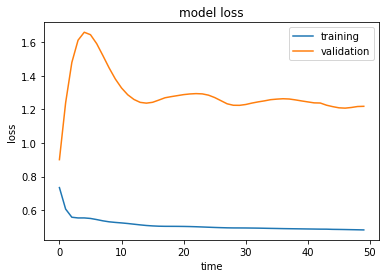

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('time')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [115]:
pred = model.predict(x_train)

In [120]:
model.evaluate(x_train, y_train)

828/828 [==============================] - 4s 4ms/step


[0.6298177702991283, 0.672705314045655]

In [121]:
model.evaluate(x_test, y_test)

96/96 [==============================] - 0s 5ms/step


[0.6224477688471476, 0.7083333333333334]

In [125]:
pred_train = model.predict_classes(x_train)

[0.67270531]


Text(0.5, 15.0, 'Predicted label')

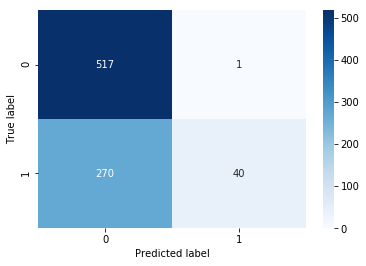

In [127]:
# Accuracy
print(sum(pred_train==y_train)/len(y_train))

cm = confusion_matrix(y_train,pred_train)
sns.heatmap(confusion_matrix(y_train,pred_train),annot=True,fmt='d',cmap="Blues") 
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 15.0, 'Predicted label')

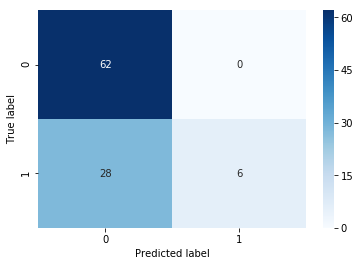

In [128]:
pred_test = model.predict_classes(x_test)
# Accuracy
#print(sum(predict_classes==y_test)/len(y_test))

cm = confusion_matrix(y_test,pred_test)
sns.heatmap(confusion_matrix(y_test,pred_test),annot=True,fmt='d',cmap="Blues") 
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [132]:
f1_score(y_test, pred_test)